# Clean light curves

### Open raw FITS files from MAST, clean out `nan`s

Save copies to `raw_long`, `raw_short` directories. 

In [86]:
#%load_ext autoreload
#%autoreload 2

import os
from glob import glob
import datacleaner
reload(datacleaner)
from datacleaner import LightCurve
import numpy as np

path_to_fits_files = '/local/tmp/hat11/010748390/'

# Retrieve long and short cadence data
long_cadence_paths = glob(os.path.join(path_to_fits_files, '*llc.fits'))
short_cadence_paths = glob(os.path.join(path_to_fits_files, '*slc.fits'))

long_lc = LightCurve.from_raw_fits(long_cadence_paths, name='raw_long')
short_lc = LightCurve.from_raw_fits(short_cadence_paths, name='raw_short')

data_path = '/astro/users/bmmorris/git/hat-11/data'
long_lc.save_to(data_path)
short_lc.save_to(data_path)

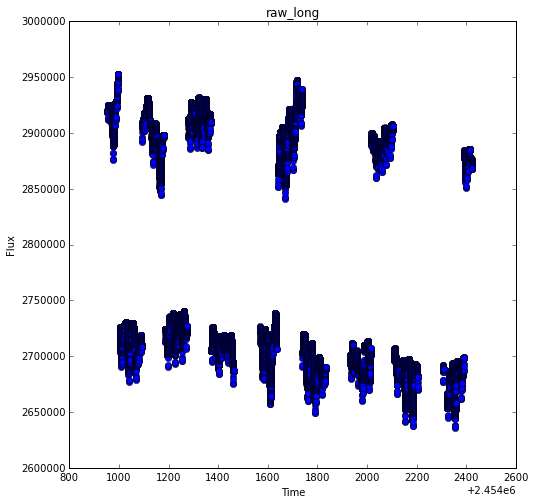

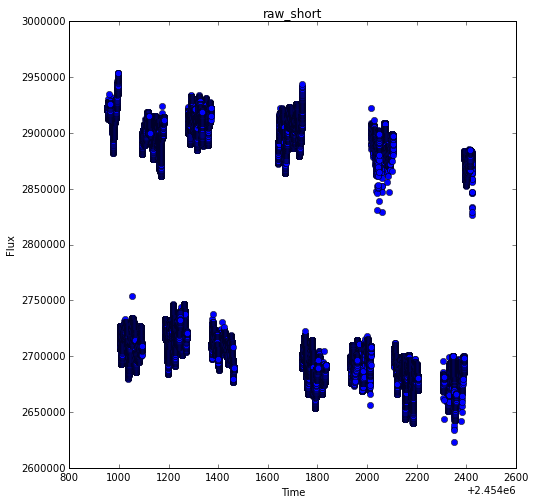

In [87]:
%matplotlib inline
long_lc.plot()
short_lc.plot()

### Normalize by quarter

For each quarter, fit a $O$(2) polynomial and divide the light curve by that polynomial. Save to `normalized_long` and `normalized_short`

/astro/apps6/anaconda2.0/lib/python2.7/site-packages/numpy/lib/polynomial.py:588: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/astro/apps6/anaconda2.0/lib/python2.7/site-packages/numpy/lib/polynomial.py:588: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/astro/apps6/anaconda2.0/lib/python2.7/site-packages/numpy/lib/polynomial.py:588: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/astro/apps6/anaconda2.0/lib/python2.7/site-packages/numpy/lib/polynomial.py:588: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/astro/apps6/anaconda2.0/lib/python2.7/site-packages/numpy/lib/polynomial.py:588: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/astro/apps6/anaconda2.0/lib/python2.7/site-packages/numpy/lib/polynomial.py:588: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/astro/apps6/anaconda2

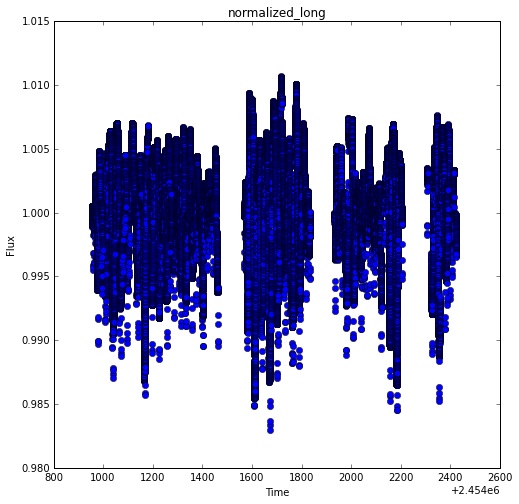

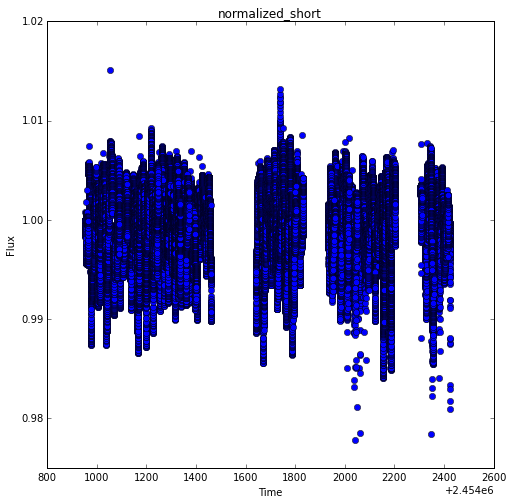

In [103]:
# Fit 2nd order polynomial to each quarter, divide to normalize
long_lc.normalize_each_quarter(rename='normalized_long')
short_lc.normalize_each_quarter(rename='normalized_short')

# Plot results, save
long_lc.plot()
short_lc.plot()

long_lc.save_to(data_path)
short_lc.save_to(data_path)

### Break out individual transits

Separate light curve into individual transits by masking out the out-of-transit portions of the light curve and separating the big `LightCurve` object into lots of little `TransitLightCurve` objects.

Then fit the out-of-transit portions of each transti for a linear baseline trend, and divide it out.

In [89]:
from datacleaner import LightCurve
short_transits = LightCurve(name='transits_short', **short_lc.mask_out_of_transit())
transits = short_transits.get_transit_light_curves()
for transit in transits:
    transit.remove_linear_baseline()

In [90]:
# Plot, save all transits after normalization
# [transit.plot(show=False, save_path='tmp/{}.png'.format(transit.name)) for transit in transits]

### Identify "spotless" transits

* do rough model fit to each transit, including only a few transit parameters ($R_p/R_s$, $a/R_s$, $i$, $t_0$)
* Measure $\chi^2$ for best-fit model

In [91]:
# Warning: this step fits each transit in the short cadence data and is slow (~2 min)
import os
chi2_file_path = 'chi2.npy'
if not os.path.exists(chi2_file_path):
    chi2 = np.array([transit.fiducial_transit_fit() for transit in transits])
    np.save(chi2_file_path, chi2)
else:
    chi2 = np.load(chi2_file_path)

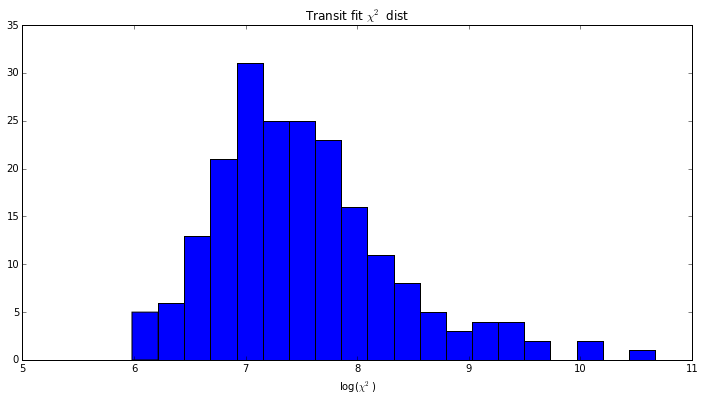

In [92]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 6))
ax.hist(np.log(chi2), 20)
ax.set(xlabel=r'log($\chi^2$)', title=r'Transit fit $\chi^2$ dist')
plt.show()

The distribution of $\chi^2$ shows that there's a long tail of poor fits to the data, and a handful of very good fits. The handful of very good fits all have $\log{\chi^2} < 6.5$. Any higher than 6.5 and there are "visible" spots in the transit. Now filter out only these transits with $\log{\chi^2} < 6.5$ for detailed transit analysis.

### Combine "spotless" light curves, fit model

[ 2454962.61440265  2454962.61508378  2454962.615765   ...,
  2456160.29739533  2456160.29807643  2456160.29875754]


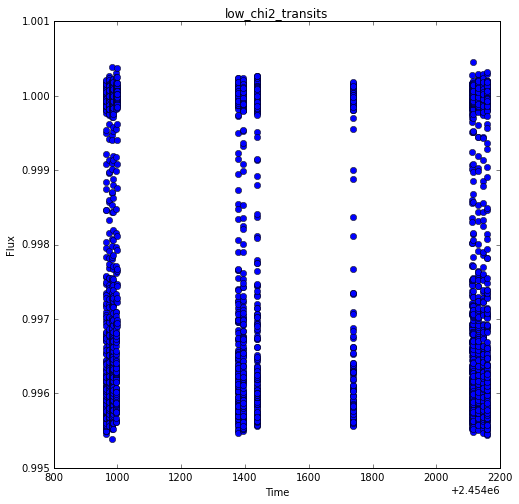

In [100]:
from datacleaner import combine_light_curves
low_chi2_transits = combine_light_curves([transit for i, transit in enumerate(transits) 
                                          if np.log(chi2[i]) < 6.5], name='low_chi2_transits')
low_chi2_transits.save_to(data_path, overwrite=True)
low_chi2_transits.plot()

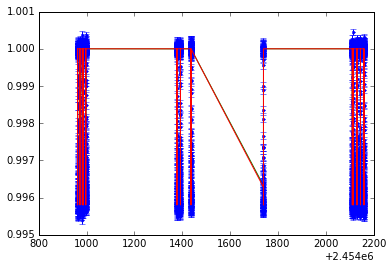

19874.894744036093

In [101]:
low_chi2_transits.fiducial_transit_fit(plots=True);

### Use `emcee` to get PDFs for interesting transit parameters

